# 🌍 Country Trends Walkthrough — Meditation Trend Pulse

This notebook demonstrates how the **Country Trends page** of the Meditation Trend Pulse Streamlit app was built.  

While the live dashboard provides an interactive experience, this notebook serves as a **static walkthrough** that:  
- Loads the same country-level datasets powering the Streamlit page  
- Reconstructs the key **tables and charts** shown in the app  
- Documents the **design choices and logic** behind each visual  

### Why this notebook matters
- Provides a **transparent record** of how country-level insights were generated  
- Shows hiring managers how global data was transformed into **regional comparisons**  
- Creates static, reproducible visuals that mirror the Streamlit experience  

### Contents
1. 📊 Total Interest by Country  
2. 🏆 Global Totals by Country & Keyword  
3. 📌 Most Frequently Featured Countries

In [1]:
# ──────────────────────────────────────────────
# 📦 Setup — Global Trends Walkthrough Notebook
# ──────────────────────────────────────────────

import os                   # File and directory operations
import pandas as pd         # Data manipulation and analysis
import matplotlib.pyplot as plt  # plotting library for static charts
from pytrends.request import TrendReq  # Google Trends API wrapper

# Configure pandas display for cleaner outputs
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
pd.set_option("display.float_format", "{:,.2f}".format)

## 📡 Initialize Pytrends Client

This cell sets up the Google Trends client and defines the core keyword set used for the **Country Trends page**.

### What this does
- Creates a `pytrends` client for querying Google Trends  
- Fixes the timezone (UTC−6) so weekly bins align consistently  
- Declares the five keywords tracked across the dashboard  

### Parameters
- `hl="en-US"` → results in English  
- `tz=360` → timezone offset in minutes (UTC−6)  
- `timeout=(15, 45)` → connection/read timeouts for stability  

### Keywords Tracked
- meditation  
- mindfulness  
- breathwork  
- guided meditation  
- yoga nidra  

In [2]:
# ──────────────────────────────────────────────
# 📡 Pytrends Client Setup
# ──────────────────────────────────────────────

# Initialize Google Trends client with clear defaults
pytrends = TrendReq(
    hl="en-US",        # Interface language
    tz=360,            # Timezone offset in minutes (UTC-6 → weekly bins align well)
    timeout=(15, 45),  # (connect timeout, read timeout) in seconds
)

# Core set of tracked keywords — consistent across project
KEYWORDS = [
    "meditation",
    "mindfulness",
    "breathwork",
    "guided meditation",
    "yoga nidra",
]

### 📥 Pulling and Reshaping Country-Level Trends Data

Next, we use **Pytrends** to fetch 5 years of search interest data at the **country level**, running one request per keyword.  
By default, Google Trends provides a **wide format** (one column per keyword, rows = countries).  

For analysis and visualization, we reshape this into a **long format**:  
- Each row now represents a `(country, keyword, interest)` triple  
- This structure is easier to rank, aggregate, and compare across keywords  
- It also matches the tidy data principles that power our Streamlit app  

This section outputs the cleaned version, showing country–keyword interest scores in a consistent structure.

In [3]:
# ──────────────────────────────────────────────
# 🌍 Pull 5-Year Country-Level Interest by Keyword
# ──────────────────────────────────────────────

frames = []  # accumulate one df per keyword

# Query region-level interest for each keyword separately
for kw in KEYWORDS:
    pytrends.build_payload([kw], timeframe="today 5-y", geo="")  # 5-year window, worldwide
    df_region = pytrends.interest_by_region()  # wide format: rows=country, cols=keyword
    
    if df_region.empty:
        continue  # skip if no data returned for this keyword

    # Normalize into tidy rows: (country, keyword, interest)
    df_kw = (
        df_region.reset_index()[["geoName", kw]]
                 .rename(columns={"geoName": "country", kw: "interest"})
                 .query("interest > 0")     # drop zero-interest rows
                 .assign(keyword=kw)        # add keyword column
    )
    frames.append(df_kw)

# Combine across keywords
df_country = (
    pd.concat(frames, ignore_index=True)
      .drop_duplicates()
      .sort_values(["keyword", "interest"], ascending=[True, False])
      .reset_index(drop=True)
)

# Preview first 10 rows
df_country.head(10)

,country,interest,keyword
0,Australia,100,breathwork
1,Ireland,73,breathwork
2,New Zealand,73,breathwork
3,Switzerland,55,breathwork
4,Netherlands,52,breathwork
5,Sweden,47,breathwork
6,Canada,46,breathwork
7,United Kingdom,42,breathwork
8,Denmark,39,breathwork
9,Austria,34,breathwork


### 📊 Visual: Country Search Interest (Top 20)

This bar chart highlights the **top 20 countries** by total Google Trends search interest across all five keywords.  
It helps identify where meditation and related practices generate the most consistent engagement globally.

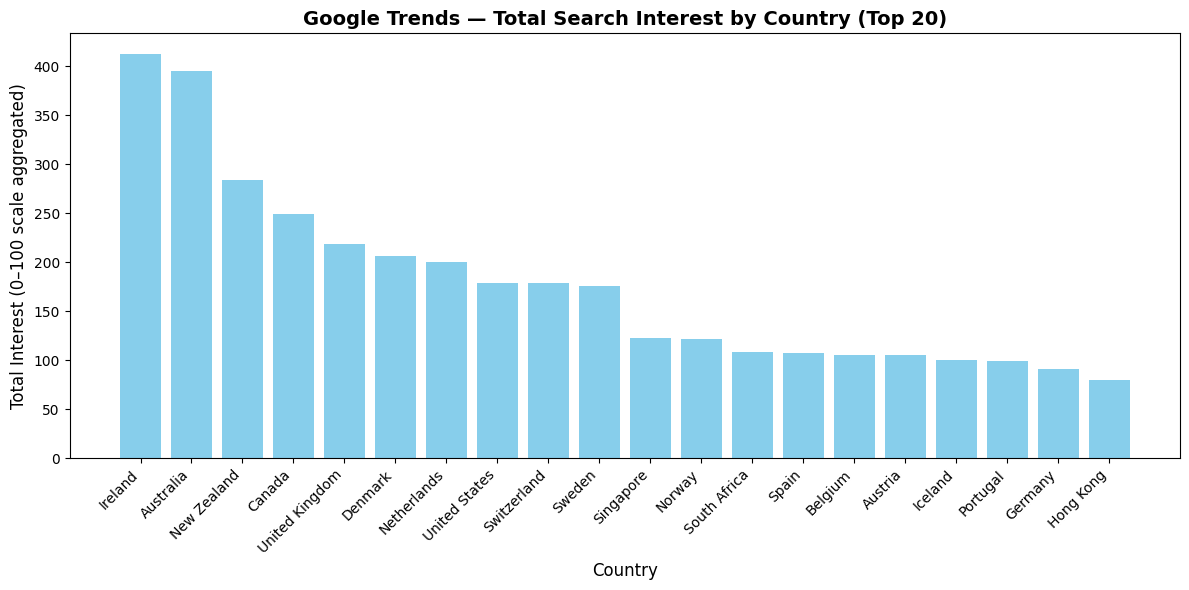

In [5]:
# ──────────────────────────────────────────────
# 🌍 Visualize Country Interest (Top 20 Countries)
# ──────────────────────────────────────────────
# Aggregate interest across keywords per country
df_country_total = (
    df_country
    .groupby("country", as_index=False)["interest"]
    .sum()
    .sort_values("interest", ascending=False)
    .head(20)
)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_country_total["country"], df_country_total["interest"], color="skyblue")

# Titles and labels
plt.title("Google Trends — Total Search Interest by Country (Top 20)", fontsize=14, weight="bold")
plt.xlabel("Country", fontsize=12)
plt.ylabel("Total Interest (0–100 scale aggregated)", fontsize=12)

# Rotate x labels for readability
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

### 🌍 Total Interest by Country (per Keyword)  

This dataset summarizes **Google Trends interest (0–100)** for each `country × keyword` pair.  
It provides a clear way to compare how different countries rank for meditation and related practices,  
mirroring the country comparison tables in the Streamlit app.  

In [14]:
# ──────────────────────────────────────────────
# 🔄 Compute Total Interest by Country & Keyword
# ──────────────────────────────────────────────

# df_country_long is expected to have: country, keyword, interest
df_country_total = (
    df_country
    .groupby(["country", "keyword"], as_index=False)
    .agg(total_interest=("interest", "sum"))
    .sort_values(["keyword", "total_interest"], ascending=[True, False])
    .reset_index(drop=True)
)

# Preview
df_country_total.head(10)

,country,keyword,total_interest
0,Australia,breathwork,100
1,Ireland,breathwork,73
2,New Zealand,breathwork,73
3,Switzerland,breathwork,55
4,Netherlands,breathwork,52
5,Sweden,breathwork,47
6,Canada,breathwork,46
7,United Kingdom,breathwork,42
8,Denmark,breathwork,39
9,Austria,breathwork,34


### 🌐 Visual: Country × Keyword Heatmap  

This heatmap compares **search interest across countries and keywords** over the past 5 years.  
Brighter cells represent higher total interest, making it easy to spot where each keyword resonates most strongly worldwide.  

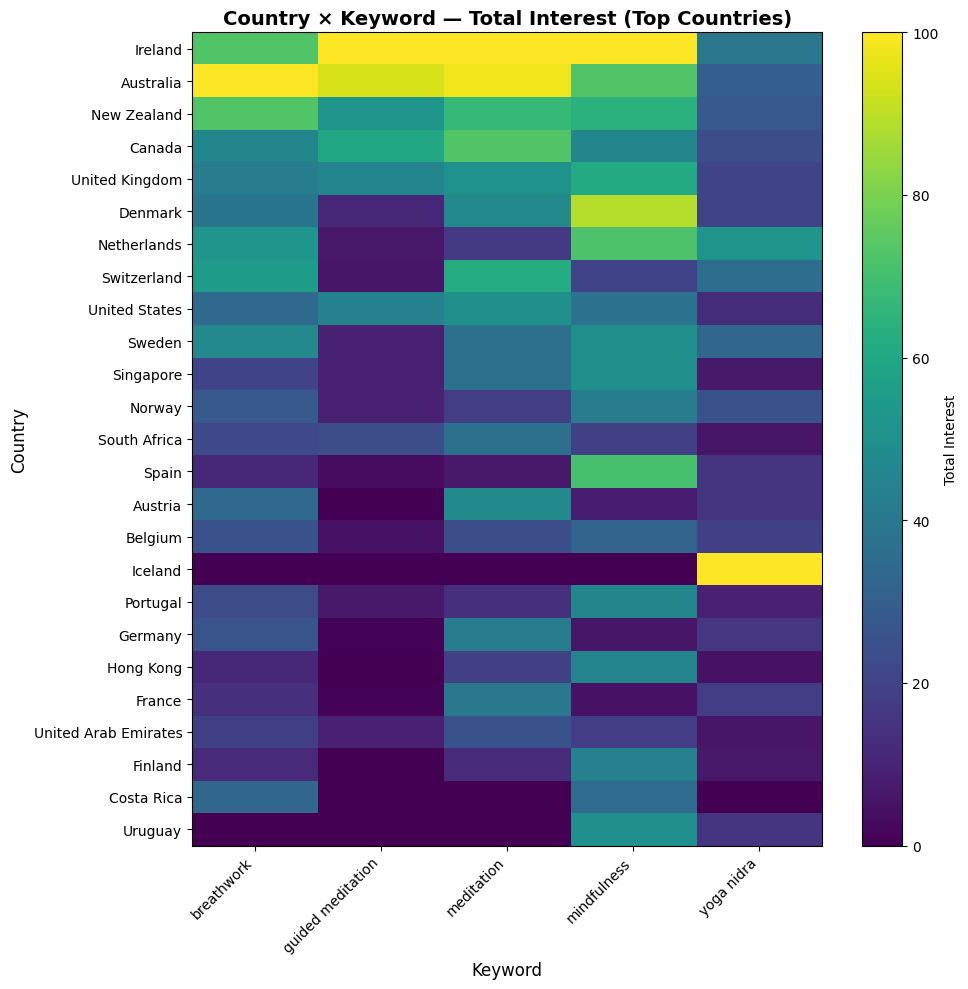

In [12]:
# ──────────────────────────────────────────────
# 🌐 Visualize: Country × Keyword Heatmap
# ──────────────────────────────────────────────
# Build a pivot table: rows=countries, cols=keywords, values=total_interest
pivot = (
    df_country_total
    .pivot(index="country", columns="keyword", values="total_interest")
    .fillna(0)
)

# (Optional) limit to top countries by overall interest to keep the figure readable
TOP_ROWS = 25
top_idx = pivot.sum(axis=1).nlargest(TOP_ROWS).index
pivot_top = pivot.loc[top_idx]

plt.figure(figsize=(10, 10))
plt.imshow(pivot_top.values, aspect="auto")
plt.title("Country × Keyword — Total Interest (Top Countries)", fontsize=14, weight="bold")
plt.xlabel("Keyword", fontsize=12)
plt.ylabel("Country", fontsize=12)

# axis ticks
plt.xticks(range(len(pivot_top.columns)), pivot_top.columns, rotation=45, ha="right")
plt.yticks(range(len(pivot_top.index)), pivot_top.index)

# colorbar
cbar = plt.colorbar()
cbar.set_label("Total Interest", rotation=90)

plt.tight_layout()
plt.show()

### 🏆 Countries with Most Top-5 Placements  

This table shows which countries most frequently appear in the **Top 5 lists** across all keywords.  
It highlights regions that are consistently dominant in meditation and mindfulness interest,  
rather than just excelling in a single keyword.  

In [23]:
# ──────────────────────────────────────────────
# 🏆 Top 5 per Keyword (mirror automation)
# ──────────────────────────────────────────────

# For each keyword: take Top-5 by interest
df_country_ranked = (
    df_country
    .sort_values("interest", ascending=False)
    .groupby("keyword", group_keys=False)
    .head(5)
)

# Add top5_count=1 (same shape as automation output)
df_country_top5_counts = (
    df_country_ranked
    .assign(top5_count=1)
    .loc[:, ["keyword", "country", "top5_count"]]
    .reset_index(drop=True)
)

df_country_top5_counts.head(10)

,keyword,country,top5_count
0,breathwork,Australia,1
1,guided meditation,Ireland,1
2,mindfulness,Ireland,1
3,meditation,Ireland,1
4,yoga nidra,Iceland,1
5,meditation,Australia,1
6,guided meditation,Australia,1
7,mindfulness,Denmark,1
8,mindfulness,Australia,1
9,meditation,Canada,1


### 🏆 Visual: Most Frequent Top-5 Countries  

This bar chart highlights the **countries that appear most often in the Top-5 rankings** for search interest across all keywords.  
It reveals regions with consistently high engagement, showing where meditation and related practices hold the strongest presence globally.  

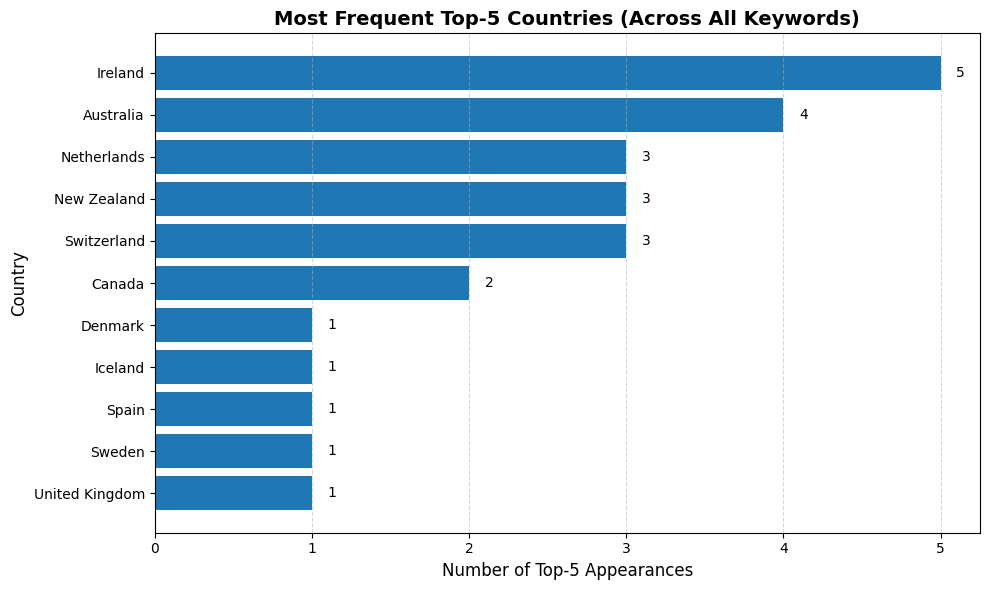

In [25]:
# ──────────────────────────────────────────────
# 🏆 Most Frequent Top‑5 Countries (Across All Keywords)
# ──────────────────────────────────────────────

# Roll up: total Top‑5 appearances per country
df_country_top5_overall = (
    df_country_top5_counts
    .groupby("country", as_index=False)["top5_count"]
    .sum()
    .rename(columns={"top5_count": "appearance_count"})
    .sort_values("appearance_count", ascending=False)
    .reset_index(drop=True)
)

# Keep Top 15 for readability
top_n = 15
df_top = df_country_top5_overall.head(top_n)


plt.figure(figsize=(10, 6))
bars = plt.barh(
    y=df_top["country"],
    width=df_top["appearance_count"],
)

# Largest at top
plt.gca().invert_yaxis()

# Titles and labels
plt.title("Most Frequent Top‑5 Countries (Across All Keywords)", fontsize=14, weight="bold")
plt.xlabel("Number of Top‑5 Appearances", fontsize=12)
plt.ylabel("Country", fontsize=12)

# Add value labels to bar ends
for bar in bars:
    w = bar.get_width()
    plt.text(w + 0.1, bar.get_y() + bar.get_height() / 2, f"{int(w)}", va="center", fontsize=10)

# Subtle grid for x‑axis
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## ✅ Conclusion — Country Trends Walkthrough  

In this notebook, we reconstructed the core elements of the **Country Trends page** from the Meditation Trend Pulse dashboard with static, reproducible visuals.  

### What we demonstrated  
- 🌍 **Total Interest by Country & Keyword** — aggregated Google Trends interest across all regions  
- 🌐 **Country × Keyword Heatmap** — side-by-side comparison of where each keyword resonates most strongly  
- 🏆 **Top-5 Appearances** — countries that most frequently rank among the global leaders for meditation interest  

### Why this matters  
This walkthrough makes the **country-level analysis transparent** and shows how raw Google Trends data was reshaped into insights for stakeholders.  
While the Streamlit app delivers interactive, filterable views, this notebook provides a **static record of the transformation pipeline** and ensures reproducibility of results.  